# Оглавление
1. [Задание](#introduction)
2. [Импорт библиотек и данных](#paragraph1)
3. [AB-тестирование](#paragraph2)  
    3.1 [t-тест](#subparagraph1)  
    3.2 [Тест Манна-Уитни](#subparagraph2)  
    3.3 [t-тест на сглаженном ctr](#subparagraph3)  
    3.4 [Пуассоновский бутстреп](#subparagraph4)  
    3.5 [t-тест поверх бакетного преобразования](#subparagraph5)   
    3.6 [Тест Манна-Уитни поверх бакетного преобразования](#subparagraph6)  
4. [Вывод](#paragraph3)

## 1. Задание <a name="Introduction"></a>

Эксперимент проводился с 2022-11-02 по 2022-11-08 включительно.  
Для эксперимента были задействованы 1 и 2 группы:
- exp_group = 1 - Все по-старому (контрольная группа)
- exp_group = 2 - Рекомендации "похожих на лайкнутые постов" (новый алгоритм рекомендации постов)

**Цель:** дать рекомендацию, стоит ли раскатывать новый алгоритм на всех новых пользователей.

**Задача**: проанализировать результаты эксперимента и проверить изменится ли метрика CTR.

За критический уровень статистической значимости взято значение 0.05  

**Описание данных:**  
- *user_id* - уникальный идентификатор пользователя  
- *action* - действие пользователя (view или like)  
- *time* - время осуществления действия пользователя  
- *exp_group* - номер экспериментальной группы

## 2. Импорт библиотек и данных <a name="paragraph1"></a>

Импортируем библиотеки

In [1]:
import pandas as pd
import pandahouse as ph
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

Импортируем данные

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': password,
    'user': user,
    'database': 'simulator_20221120'
}

In [3]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [4]:
df = ph.read_clickhouse(q, connection=connection)

## 3. AB-тестирование <a name="paragraph2"></a>

### 3.1 t-тест <a name="subparagraph1"></a>

**Нулевая гипотеза H₀:** средние значения ctr в 1 и 2 экспериментальных группах равны.  
**Альтернативная гипотеза H₁:** средние значения ctr в 1 и 2 экспериментальных группах не равны.

In [5]:
res_ttest = st.ttest_ind(df[df.exp_group == 1].ctr,
                       df[df.exp_group == 2].ctr,
                       equal_var=False)

In [6]:
# вспомог."функция" для вывода результатов теста:
def concl(name_test, results, alpha):
    print(name_test)
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha: # alpha - крит.уровень стат.значимости
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

In [7]:
concl('t-тест:', res_ttest, 0.05)

t-тест:
p-значение: 0.4780623130874935
Не получилось отвергнуть нулевую гипотезу


Посмотрим на гистограммы ctr в группах

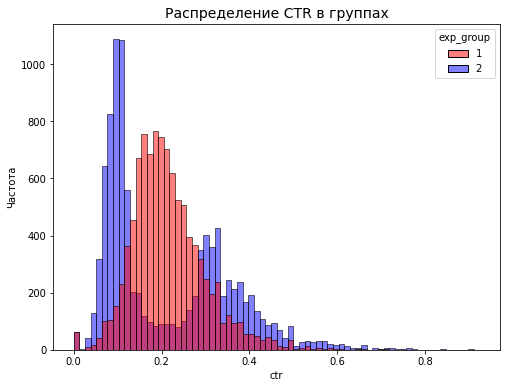

In [8]:
plt.figure(figsize=(8,6))
plt.title("Распределение CTR в группах",size=14)
plt.ylabel("Частота",size=10)
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

По графикам видим, что в группе 2 данные искажены (наблюдается ассиметрия), поэтому использование t-теста не лучший вариант.

### 3.2 Тест Манна-Уитни <a name="subparagraph2"></a>

**Нулевая гипотеза H₀:** вероятность, что ctr гр. 1 больше ctr гр. 2 равна вероятности, что ctr гр.2 больше ctr гр.1  
**Альтернативная гипотеза H₁:** вероятность, что ctr гр. 1 больше ctr гр. 2 не равна вероятности, что ctr гр.2 больше ctr гр.1

In [9]:
res_mann = st.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

In [10]:
concl('Тест Манна-Уитни:', res_mann, 0.05)

Тест Манна-Уитни:
p-значение: 6.0376484617779035e-56
Отвергаем нулевую гипотезу


### 3.3 t-тест на сглаженном ctr <a name="subparagraph3"></a>

In [11]:
# функция для расчёта сглаженного ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [12]:
# считаем глобальный ctr в 1 и 2 группах:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [13]:
# считаем сглаженный ctr для 1 и 2 групп, размер гиперпараметра берём равный 5:
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_1, 5), axis=1)

group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_2, 5), axis=1)

Проводим t-тест.

**Нулевая гипотеза H₀:** средние значения сглаженных ctr в 1 и 2 экспериментальных группах равны.  
**Альтернативная гипотеза H₁:** средние значения сглаженных ctr в 1 и 2 экспериментальных группах не равны.

In [14]:
res_smoothed_ctr_ttest = st.ttest_ind(group1.smothed_ctr,
                       group2.smothed_ctr,
                       equal_var=False)
concl('t-тест на сглаженном ctr:', res_smoothed_ctr_ttest, 0.05)

t-тест на сглаженном ctr:
p-значение: 0.0223769815558559
Отвергаем нулевую гипотезу


### 3.4 Пуассоновский бутстреп <a name="subparagraph4"></a>

In [15]:
# функция для получения распределений глобальных ctr в двух группах с использованием бутстрепа:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=3000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [16]:
# находим распределения глобальных ctr для групп 1, 2
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Посмотрим на гистограмму разности глобальных ctr

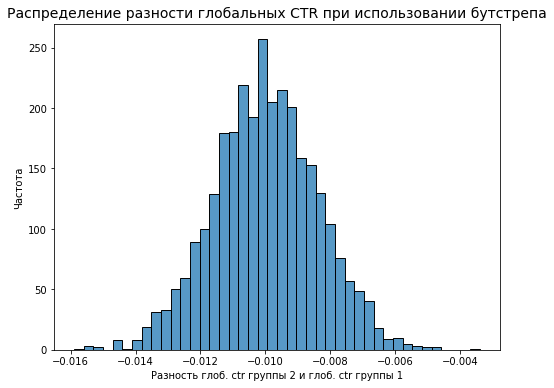

In [17]:
plt.figure(figsize=(8,6))
plt.title("Распределение разности глобальных CTR при использовании бутстрепа",size=14)
plt.ylabel("Частота",size=10)
plt.xlabel("Разность глоб. ctr группы 2 и глоб. ctr группы 1",size=10)
diff = sns.histplot(ctr2-ctr1)

По графику видно, что разность не достигает 0 , т.е. имеем различия в глобальных ctr. Также глобальный ctr в первой группе больше глобального ctr во второй группе. На основе этого можем утверждать, что в тестовой группе ctr меньше, чем в контрольной.

Проведем t-test

**Нулевая гипотеза H₀:** средние значения глобальных ctr в 1 и 2 экспериментальных группах равны.  
**Альтернативная гипотеза H₁:** средние значения глобальных ctr в 1 и 2 экспериментальных группах не равны.

In [18]:
bootstrap_ttest = st.ttest_ind(ctr1,
                       ctr2,
                       equal_var=False)
concl('t-тест по метрике глобальных ctr при использовании пуассоновского бутстрепа:', bootstrap_ttest, 0.05)

t-тест по метрике глобальных ctr при использовании пуассоновского бутстрепа:
p-значение: 0.0
Отвергаем нулевую гипотезу


По t-тесту также получаем различие в средних глобальных ctr между группами 1 и 2.

### 3.5 t-тест поверх бакетного преобразования <a name="subparagraph5"></a>

Импортируем данные для бакетного преобразования (количество бакетов берём 200, исходя из обычной практики (статьи) Авито и VK)

In [19]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%200 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-11-02' and '2022-11-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_b = ph.read_clickhouse(q, connection=connection)

Посмотрим на распределения побакетного ctr

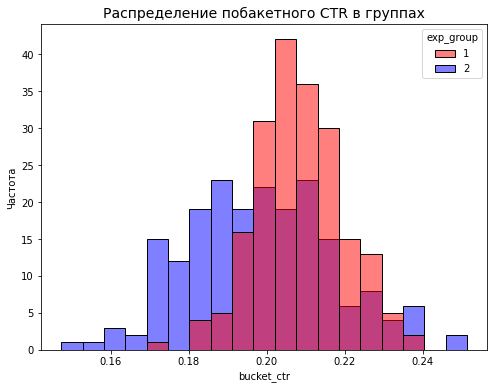

In [20]:
plt.figure(figsize=(8,6))
plt.title("Распределение побакетного CTR в группах",size=14)
plt.ylabel("Частота",size=10)
groups = sns.histplot(data = df_b, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На графике видно, что побакетный ctr группы 1 в среднем больше побакетного ctr группы 2. Также видим, что распределения похожи на нормальные.

Проведём t-тест

**Нулевая гипотеза H₀:** средние значения побакетного ctr  в 1 и 2 экспериментальных группах равны.  
**Альтернативная гипотеза H₁:** средние значения побакетного ctr в 1 и 2 экспериментальных группах не равны.

In [21]:
bucket_ttest = st.ttest_ind(df_b[df_b.exp_group == 1].bucket_ctr,
                       df_b[df_b.exp_group == 2].bucket_ctr,
                       equal_var=False)

concl('t-тест по метрике побакетного ctr:', bucket_ttest, 0.05)

t-тест по метрике побакетного ctr:
p-значение: 6.483418342277103e-10
Отвергаем нулевую гипотезу


### 3.6 Тест Манна-Уитни поверх бакетного преобразования <a name="subparagraph6"></a>

**Нулевая гипотеза H₀:** вероятность, что побакетный ctr гр. 1 больше побакетного ctr гр. 2 равна вероятности, что побакетный ctr гр.2 больше побакетного ctr гр.1  
**Альтернативная гипотеза H₁:** вероятность, что побакетный ctr гр. 1 больше побакетного ctr гр. 2 не равна вероятности, что побакетный ctr гр.2 больше побакетного ctr гр.1  

In [22]:
bucket_mann = st.mannwhitneyu(df_b[df_b.exp_group == 1].bucket_ctr, 
                   df_b[df_b.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')
concl('t-тест поверх бакетного преобразования:', bucket_mann, 0.05)

t-тест поверх бакетного преобразования:
p-значение: 5.074234405206183e-10
Отвергаем нулевую гипотезу


## 4. Вывод <a name="paragraph3"></a>

- С учётом наличия ассиметричности данных использование t-теста нецелесообразно. Ассиметричность данных в группе 2 может быть связана, например, с тем, что алгоритм работает некорректно: в ленте повторяются интересные посты, которым уже ставили лайк и нет возможности поставить его снова (т.е. пользователь может псмотреть понравившийся пост снова, но поставить снова лайк не может). Также можно проверить корректность работы кнопки "лайк" (т.е. пользователь не может поставить лайк или лайк "не считывается").
- Для нашего исследования на таких (ассиметричных) данных рациональнее использовать либо Пуассоновский бутстреп с оценкой глобальных ctr, либо t-тест, тест Манна-Уитни поверх бакетного преобразования c оценкой побакетных ctr.
- При анализе разницы в глобальных ctr и анализе побакетных ctr между группами 1 и 2 мы отметили, что ситуация с оцениваемыми метриками в группе 2 ухудшилась. Поэтому раскатывать новый алгоритм в текущем варианте на всех новых пользователей не рекомендуется.